**DISSECTING AIRBNB (Boston) REVIEW SCORES: WHAT MAKES A GOOD AIRBNB?**

* the following code will use the following dataset https://www.kaggle.com/airbnb/boston to see what relates to Boston Airbnb prices and review score ratings. The aim is to answer the following questions:

  * *Using random forest regression feature ranking, what are the top predictors of overall review scores?*
  * *When we use a multilevel model, which of these features are statistically significant?*
  * *Out of the statistically significant features, which have large effect sizes? What are the directions?*
  
* besides indicating major function blocks, the markdown cells indicate major points in the CRISP-DM process (labelled as gather, assess, clean, analyze, model, visualize.

* the code in the cell for txt_df can take a while to run so a file of the output is provided that can be read in. 

In [84]:
# basic imports
import pandas as pd
import numpy as np
import seaborn as sns
import re
from re import sub

import statistics
from string import punctuation

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.inspection import permutation_importance

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag

import plotly.graph_objs as go

import statsmodels.api as sm
import statsmodels.formula.api as smf

**RANDOM FOREST FUNCTIONS**

* these functions are used to help run and shape random forest regressor results.

In [153]:
#exec(open("./randomforestfunctions.py").read())
def prep_for_rf(response_col, df, colsub = 5, nested = 5):
    '''
    INPUT:
    y var/response col, the dataframe, a substring (of related variables one might want to omit, 
    in this case the sub-components of total review scores), and possibly a nested var.
    
    Defaults are set to arbitrary numeric values for colsub and nested for the isinstance if statements 
    
    OUTPUT:
    X and ys that have had nans properly addressed
    
    STEPS:
        1. This function drops all rows that are missing the dependent variable/y variable.
        2. If colsub has a value, it drops columns with that regex
        3. If nested has a value, it groups by this value and finds the mean within the nested value
        (along the lines of person-mean imputation).  This is to try to improve the accuracy of the
        mean imputation, and preserve differences between people. So in this case, if a listing appears
        twice, and the value for beds is for some reason missing in one, it is imputed with the average 
        # of beds (Nas ignored by default) for this listing, not the average number of beds overall.
        4. Finally, if there is no other option, it will fill nas with the general mean
        5. IF there is no nested variable, it will simply fill the nas with the mean.
        6. returns as X, y
    '''
    fillmean = lambda col: col.fillna(col.mean())
    df2 = df.copy()
    df2 = df2.dropna(subset = [response_col], axis = 0).reset_index(drop = True)
    if isinstance(colsub, str):
        X = df2[df2.columns.drop(list(df2.filter(regex=colsub)))]
        X = X.reset_index(drop = True)
    if isinstance(nested, str):
        X = X.groupby([nested]).transform(lambda x: x.fillna(x.mean()))
        X[nested] = df2[nested]
        X = X.apply(fillmean)
    else:
        X = X.apply(fillmean)
    y = df2[response_col]
    return(X, y)

def run_modelskfold(function, X, y, kfoldn = 10, n_rep = 5, pi_bool = True):
    '''
    INPUT:
    scikit rf regressor model, x vals, y vals, number of kfold splits, # of permutations,
    boolean whether or not to find permutation importances for kfold across trials
    
    OUTPUT:
    mae scores, mse scores, feature ranking
    
    STEPS:
        1. Initialize the accuracy of the models to blank lists. Respective vals will be appended to this list
        2. iterate over kfold splits
        3. if pi_bool == True 
            a. then use scikit's permutation importance to see which features are most important
            b. concatenate into labeled df.
            c. transform into long format
            d. label the sum of scores as 'importance' and indexers as 'labels'(will feed into further functions better in this format)
        4. return list containing (1. list of mean absolute error, 2. list of mean squared error, 3. list of dfs of permutation importance)
            
      
    '''
    kf = KFold(n_splits=kfoldn,shuffle=True)
    mae_ = []
    mse_ = []
    per_imps = []
    # Iterate over each train-test split
    for train_index, test_index in kf.split(X):
        # Split train-test
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # Train the model
        model = function.fit(X_train, y_train)
    # Append to accuracy_model the accuracy of the model
        mae_.append(mean_absolute_error(y_test, model.predict(X_test)))
        mse_.append(mean_squared_error(y_test, model.predict(X_test)))
   
        if pi_bool == True:
            result = permutation_importance(function, X_test, y_test, n_repeats=n_rep,
                                random_state=42, n_jobs=2)
            sorted_idx = result.importances_mean.argsort()
            perm_imp = pd.DataFrame(result.importances[sorted_idx].T)
            perm_imp.columns = X_test.columns[sorted_idx]
            perm_imp = perm_imp.T.rename_axis("labels")
            perm_imp['importance'] = perm_imp.mean(axis = 1)
            perm_imp = perm_imp.reset_index()
            
            per_imps.append(perm_imp)
    return([mae_, mse_, per_imps])

def run_each_participant(function, X, y, feat_bool = True):
    '''
    INPUT:
    scikit rf regressor model, x vals, y vals, boolean whether or not to find feature importances
    
    OUTPUT:
    mae scores, mse scores, feature ranking
    '''
    X = X.copy()
    y = y.copy()
    accuracy_model = []
    mse_ = []
    feat_imps = []
    
    for i in range(0,len(X[X.columns[0]])):
        
        X_test = X.loc[i]
        y_test = pd.Series(y[i])
        X_test = X_test.values.reshape(1, -1)
        
        X_train = X.drop(X.index[i])
        y_train =np.delete(y, i)
        model = function.fit(X_train, y_train)
        
        accuracy_model.append(mean_absolute_error(y_test, model.predict(X_test)))
        mse_.append(mean_squared_error(y_test, model.predict(X_test)))
        if feat_bool == True:
            feat_imp = pd.DataFrame({
    
                'labels': X_train.columns,
                'importance':model.feature_importances_
            })

            feat_imp = feat_imp.reset_index(drop = True)
            feat_imp = feat_imp.sort_values(by = 'importance', axis = 0)
            feat_imps.append(feat_imp)
    
    return([accuracy_model, mse_, feat_imps])

def specify_best(model, X, y, typ = 'RF'):
    '''
    INPUT:
    scikit regressor model, x vals, y vals, str telling if it is rf or svr
    
    OUTPUT:
    best parameter values for min samples split, max features, or kernel gamma and C
    '''
    if typ == 'RF':
        params =  {'min_samples_split': np.arange(2, 100, 20), 'max_features': np.arange(2,15,4)}
    elif typ == 'svr':
         params =  {'kernel': ['rbf', 'linear', 'sigmoid'], 'gamma': np.arange(0.001,0.9,0.1), 'C': [0.0001,0.01,1,10,100]}
    clf = GridSearchCV(model, params,cv = 5)
    clf.fit(X, y)
    print(clf.best_params_)
    return(clf.best_params_)

def top_features(feat_imps, featn = 15, mean = False):
    '''
    INPUT:
    result df from run_each_participant, number of features you want returned, or if you want cutoff to be mean
    only can use one at a time.
    
    OUTPUT:
    most important features, their importances, and frequency of models that they appeared in (as greater than mean or top featn)
    
    STEPS:
        1. iterate through feat_imps, creat index var showing which trial it came from and reformat
        2. concatenate this into one dataframe
        3. fill nas (instances where a feature didn't occur) with zero (same as feature not occuring)
        4. create a series of mean_vals
        5. whichever selection method you chose, will use this series to select the topn or the > mean features
        6. using the names/index from this series it will count how often they occur
        6. create and return new dataframe.
    '''
    all_feat = []
    count = 0
    
    for i in feat_imps:
        i = i.reset_index(drop = False)
        i['index'] = [count]*len(i['index'])
        i = i.pivot(index = 'index', columns='labels', values='importance')
        all_feat.append(i)
        count += 1
    
    all_feat_df = pd.concat(all_feat, axis = 0)
    all_feat_df_filled = all_feat_df.fillna(0)
    mean_feat = all_feat_df_filled.mean(axis = 0)
    if mean == False:
        top_feat = mean_feat.sort_values().iloc[len(mean_feat)-featn: len(mean_feat)]
    else:
        top_feat = mean_feat.sort_values()
        top_feat = top_feat.where(top_feat > np.mean(top_feat.values))
        top_feat = top_feat.dropna()
        
    names = top_feat.index
    count_feat = all_feat_df.count(axis = 0)
    count_feat_sub = count_feat.loc[list(names)]
    
    top_feat_df = pd.DataFrame({
        'features':names,
        'feat_imps':top_feat.values,
        'count_models': count_feat_sub.values
    })
    return(top_feat_df)
    
def print_vals(best_param, run_list, top_feat_df):
    
    print('mss: ' + str(best_param.get('min_samples_split')))
    print('max_feat: ' + str(best_param.get('max_features')))
    print('mean_mae: ' + str(np.mean(run_list[0])))
    print('mean_mse: '+ str(np.mean(run_list[1])))
    print('\n' + 'frequency: ' + '\n')
    for i in list(top_feat_df['count_models']):
        print(i)  
    print('\n' + 'feat_imp: ' + '\n')
    for i in list(top_feat_df['feat_imps']):
        print(i)
    print('\n' + 'top_ features' + '\n')
    for i in list(top_feat_df['features']):
        print(i)

**TEXT CLASS**
* these extend the string class to make extracting relevant numerical features easier

In [3]:
#exec(open("./fancy_string.py").read())

class FancyString(str):
    '''
    Extends string class for basic nlp tasks
            
    '''
    
    def __init__(self, sent):
        self.txt = sent

    def wordcount(self):
        split = self.split()
        self.length = (len(split))
        return(self.length)
    
    def ad_count(self):
        z = nltk.word_tokenize(self)
        meh = nltk.pos_tag(z)
        adj = 0
        for i in meh:
            if (i[1] == 'RB') or (i[1] == 'JJ'):
                adj += 1
        self.ad_count = adj
        return(self.ad_count)


**CLEANING FUNCTIONS**

- the following functions are used for dataframe manipulation and cleaning

In [ ]:
#exec(open("./dataframe_functions.py").read())
def to_money(val):
    '''
    INPUT:
    str formatted $1,000.00 indicating monetary value 
    
    OUTPUT:
    float of monetary value
    '''
    val = val[1:len(val)-3]
    val = val.replace(',', '')
    return(float(val))

def col_to_money(colname, df):
    '''
    INPUT:
    colname to be converted, dataframe that hosts column 
    
    OUTPUT:
    the column, in a float format
    '''
    return ([to_money(i) if isinstance(i, float) == False else None for i in df[colname]])

def col_from_percent(colname, df):
    '''
    INPUT:
    colname to be converted, dataframe that hosts column 
    
    OUTPUT:
    the column, in a float format
    '''
    return([float(i.replace('%', ''))if isinstance(i, float) == False else None for i in df[colname]])

def flatten_multiindex(df):
    '''
    INPUT:
    df with multiindex (usually result of multiple agg steps)
    
    OUTPUT:
    new colnames
    should be used df.columns = flatten_multiindex(df)
    '''
    return(['_'.join(col).strip() for col in clean_agg.columns.values])

def create_dummy_df(df, cat_cols, dum_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
            
    '''
    new_df = df.copy()
    for col in  cat_cols:
        try:
            dums =  pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dum_na)
            new_df = pd.concat([new_df.drop(col, axis=1),dums], axis=1)
        except:
            continue
    return new_df

def list_to_cols(series):
    '''
    INPUT:
    series consisting of a list 
    
    OUTPUT:
    dataframe where items in the list are columns
    '''
    column_names = []
    for i in series:
        for n in i:
            if n not in column_names:
                column_names.append(n)
    df = pd.DataFrame(columns = column_names)
    for z in column_names:
        df[z] = [1 if z in x else 0 for x in series]
    return(df)

def text_to_cols(colname, df):
    '''
    INPUT:
    str column name and dataframe that contains it 
    
    OUTPUT:
    dataframe with new columns containing str properties, original str column removed
    '''
    fancy_strings = [FancyString(i) for i in df[colname]]
    df[colname + '_adcount'] = [i.ad_count() for i in fancy_strings]
    df[colname + '_wordcount'] = [i.wordcount() for i in fancy_strings]
    df = df.drop(colname, axis = 1)
    return(df)

**STATSMODELS**
* The following functions are used for statistical modelling

In [183]:
def mlm(str_x, str_y, str_group, df, nested):
    '''
    INPUT:
    string of independent var, string of dependent var, string of group, df hosting, string of nested group if relevant
    
    OUTPUT:
    a statsmodel instance of a mixed effects/multilevel model
    '''
    if isinstance(nested, str):
        vcf = {nested: "0 +C(" + nested + ")"}
    else:
        vcf = None
    model = str_y + " ~ " + str_x
    md = smf.mixedlm(model, df, groups = df[str_group], vc_formula = vcf)
    mdf = md.fit()
    return(mdf)

**GATHER**

In [5]:
#collecting relevant dataframes
listings = pd.read_csv('./listings.csv', index_col = 0).reset_index()
reviews = pd.read_csv('./reviews.csv', index_col = 0).reset_index()
full_df = reviews.merge(listings, left_on = 'listing_id', right_on = 'id', how = 'inner')

**ASSESS**

* there is consistent missingness that will have to be addressed
* there are many objects requiring examination
* it's multilevel, so will have to aggregate for Random Forests etc
* there are many instances of variable clusters (around review_score etc) where it is likely that vars are highly correlated

In [93]:
print(full_df.shape)
print("\n")
print(full_df.info())
print("\n")
full_df.describe()

(68275, 101)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 68275 entries, 0 to 68274
Columns: 101 entries, listing_id to reviews_per_month
dtypes: float64(18), int64(18), object(65)
memory usage: 53.1+ MB
None




,listing_id,id_x,reviewer_id,id_y,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,calculated_host_listings_count,reviews_per_month
count,6.827500e+04,6.827500e+04,6.827500e+04,6.827500e+04,6.827500e+04,6.827500e+04,68275.000000,68275.000000,0.0,68275.000000,...,68197.000000,68202.000000,68200.000000,68202.000000,68197.000000,68199.000000,0.0,0.0,68275.000000,68275.000000
mean,4.759910e+06,5.246516e+07,2.802389e+07,4.759910e+06,2.016091e+13,1.444614e+07,13.972830,13.972830,NaN,42.338246,...,9.474684,9.316868,9.705777,9.703953,9.361145,9.234564,NaN,NaN,5.141721,3.669015
std,3.788990e+06,2.790991e+07,2.234097e+07,3.788990e+06,6.585986e+00,1.635912e+07,66.806719,66.806719,NaN,0.026307,...,0.655534,0.834400,0.521058,0.514301,0.721928,0.649583,NaN,NaN,10.991914,2.492277
min,3.353000e+03,1.021000e+03,1.430000e+02,3.353000e+03,2.016091e+13,4.240000e+03,1.000000,1.000000,NaN,42.235942,...,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,NaN,NaN,1.000000,0.010000
25%,1.458081e+06,3.010420e+07,9.001346e+06,1.458081e+06,2.016091e+13,2.005394e+06,1.000000,1.000000,NaN,42.318251,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,NaN,NaN,1.000000,1.710000
50%,4.080000e+06,5.223121e+07,2.305179e+07,4.080000e+06,2.016091e+13,8.157833e+06,2.000000,2.000000,NaN,42.343722,...,10.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,NaN,2.000000,3.220000
75%,7.377034e+06,7.663248e+07,4.213454e+07,7.377034e+06,2.016091e+13,2.185136e+07,6.000000,6.000000,NaN,42.357792,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,5.000000,5.330000
max,1.484378e+07,9.999045e+07,9.335034e+07,1.484378e+07,2.016091e+13,9.287818e+07,749.000000,749.000000,NaN,42.389982,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,136.000000,19.150000


**CLEAN**
* eliminate any completely empty rows or columns
* reformat objects that should be numbers 
* for amenities in particular, have to transform json-like bracket into list
* for text vars convert to word count and adjective count
* sift through and remove variables that won't be meaningful (such as city (they are all in boston)), or are redundant
* convert objects to dummy var dataframes
* concatenate and aggregate on listing id and then host id

In [6]:
#clean
#eliminate any fully empty rows or columns and retain an item-level index
full_df = full_df.dropna(axis = 0, how = 'all')
full_df = full_df.dropna(axis = 1, how = 'all')


In [7]:
#reformatting data types that should be floats but are currently obj

money_col_list = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
for i in money_col_list:
    full_df[i + '_float'] = col_to_money(i, full_df)
    
percent_col_list = ['host_response_rate', 'host_acceptance_rate']
for i in percent_col_list:
    full_df[i] = col_from_percent(i, full_df)

In [8]:
#reformatting amenities:  in original dataframe, strings not in "" are options, while strings in "" are offered.
#for our purposes, retain only the offered options 

full_df['amenities'] = [re.findall('"([^"]*)"', i) if isinstance(i, float) == False else None for i in full_df['amenities']]
amenities = list_to_cols(full_df['amenities'])

amenities =create_dummy_df(amenities,list(amenities.columns), True)
#this looks like an error/missing data so these vals were dropped
amenities = amenities[amenities.columns.drop(list(amenities.filter(regex='translation missing')))]

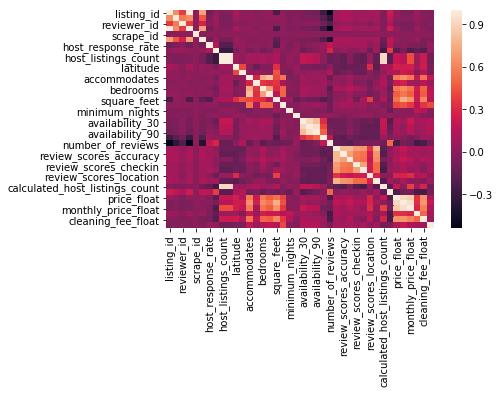

In [9]:
num_df = full_df.select_dtypes(include=['float64', 'int64']).copy().reset_index(drop = True)
sns.heatmap(num_df.corr(), annot=False, fmt=".2f");

In [10]:
#clean
text_cols = ['comments', 'name', 'summary', 'space', 'description','house_rules']
#txt_df = full_df[text_cols].copy()

#for i in text_cols:
 #   txt_df = text_to_cols(i, txt_df)

In [11]:
#txt_df.to_csv('./txt_df.csv')
txt_df = pd.read_csv('./txt_df.csv')

In [12]:
txt_df = txt_df.drop(txt_df.columns[0], axis=1)

In [65]:
bad_objs = "calendar_updated price extra_people smart_location cleaning_fee security_deposit amenities first_review last_review city zipcode weekly_price neighbourhood_cleansed host_since monthly_price calendar_last_scraped date reviewer_name listing_url neighborhood_overview last_scraped experiences_offered notes transit access interaction thumbnail_url medium_url picture_url xl_picture_url host_url host_name host_location host_about host_thumbnail_url host_picture_url host_neighbourhood host_verifications host_has_profile_pic street"
bad_objL = bad_objs.split()

obj_df = full_df.select_dtypes(include=['object']).copy()
obj_df = obj_df.drop(text_cols, axis = 1)
obj_df = obj_df.drop(bad_objL, axis = 1)

In [66]:
obj_df =create_dummy_df(obj_df,list(obj_df.columns), True)
obj_df = obj_df.reset_index(drop = True)

obj_df2 = pd.concat([obj_df, amenities], axis = 1)

obj_df2 = obj_df2[obj_df2.columns.drop(list(obj_df2.filter(regex='index')))]


In [150]:
clean_df = pd.concat([num_df, obj_df2], axis = 1)
clean_df = clean_df[clean_df.columns.drop(list(clean_df.filter(regex='id')))]

clean_df['listing_id'] = full_df['listing_id']
clean_df['host_id'] = full_df['host_id']
clean_df = pd.concat([clean_df, txt_df], axis = 1)
clean_df = clean_df.loc[:, (clean_df != 0).any(axis=0)]

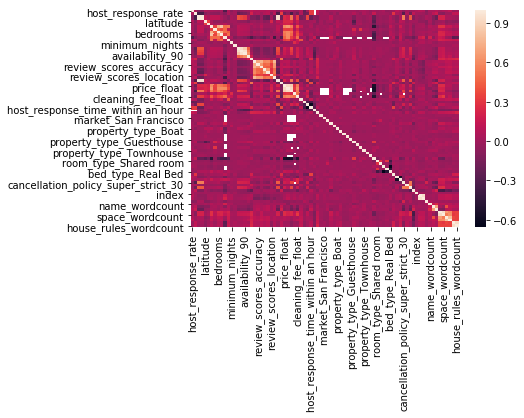

In [18]:
sns.heatmap(clean_agg.corr(), annot=False, fmt=".2f");

In [186]:
cleanedX, cleanedy = prep_for_rf('review_scores_rating',clean_df, 'review_scores', nested = 'listing_id')
clean_df_filled = pd.concat([cleanedX,cleanedy], axis = 1)
clean_df_filled.columns = clean_df_filled.columns.str.replace(".", "_")
clean_df_filled.columns = clean_df_filled.columns.str.replace(" ", "_")

In [ ]:
clean_agg = clean_df_filled.groupby(['listing_id']).agg('mean').reset_index(drop = True)
clean_agg = clean_agg.groupby(['host_id']).agg(['mean']).reset_index(drop = False)
clean_agg.columns = flatten_multiindex(clean_agg)

In [156]:
best_param = specify_best(model = RandomForestRegressor(random_state = 15), typ = 'RF', X = X, y = y)

rf = RandomForestRegressor(min_samples_split=best_param.get('min_samples_split'), 
                           max_features= best_param.get('max_features'),random_state = 15)

{'max_features': 14, 'min_samples_split': 62}


In [180]:
X = clean_agg.drop(['index_mean','review_scores_rating_mean'], axis = 1)
y = clean_agg['review_scores_rating_mean']

In [181]:
rf_res = run_modelskfold(rf, X, y, pi_bool = True)

results = top_features(rf_res[2], mean = True)
print_vals(best_param, rf_res, results)

mss: 62
max_feat: 14
mean_mae: 5.269095769858627
mean_mse: 63.66665469245745

frequency: 

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10

feat_imp: 

0.0012356920772716262
0.0014223917814314567
0.0016436998330776463
0.001650593291167616
0.001732212337660855
0.002051211019639885
0.0023790791598936037
0.002504800547552084
0.0025712319816586547
0.0026224670063998293
0.0032487465140214806
0.003731258759013145
0.003801915986453032
0.004468291563780022
0.004568319241056586
0.004737095597177177
0.005343753854514037
0.007545974269732114
0.012176991983677306
0.012977903575691587
0.025977851666221206
0.030648963748985052

top_ features

Hot_Tub_1_0_mean
Hair_Dryer_1_0_mean
Laptop_Friendly_Workspace_1_0_mean
Smoking_Allowed_1_0_mean
latitude_mean
house_rules_wordcount_mean
weekly_price_float_mean
longitude_mean
Fire_Extinguisher_1_0_mean
availability_365_mean
number_of_reviews_mean
calculated_host_listings_count_mean
description_wordcount_mean
comments_adcount_mean
host_listin

In [182]:
fig = go.Figure()
fig.add_trace(go.Bar(x=results['features'], y = results['feat_imps'], name = 'Ratings_Score_Top_Pred'))

In [187]:
multilevel_models = []
for i in results['features']:
    i = i.replace('_mean', '')
    mlm_i = mlm(str_x = str(i), str_y = 'review_scores_rating', str_group = 'host_id', df= clean_df_filled, nested = 'listing_id')
    multilevel_models.append(mlm_i)
    print(mlm_i.summary())

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: review_scores_rating
No. Observations: 68210   Method:             REML                
No. Groups:       1731    Scale:              0.0000              
Min. group size:  1       Log-Likelihood:     628471.5217         
Max. group size:  1448    Converged:          Yes                 
Mean group size:  39.4                                            
-------------------------------------------------------------------
                  Coef.   Std.Err.     z      P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept         92.007     0.037  2465.317  0.000  91.934  92.080
Hot_Tub_1_0       -1.986     0.174   -11.392  0.000  -2.328  -1.645
listing_id Var     3.684  1429.570                                 

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: review_scores_rating
No. Observations: 

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: review_scores_rating
No. Observations: 68210   Method:             REML                
No. Groups:       1731    Scale:              0.0000              
Min. group size:  1       Log-Likelihood:     628693.7744         
Max. group size:  1448    Converged:          Yes                 
Mean group size:  39.4                                            
-------------------------------------------------------------------
                  Coef.   Std.Err.     z      P>|z|  [0.025  0.975]
-------------------------------------------------------------------
Intercept         92.972     0.061  1528.381  0.000  92.853  93.091
availability_365  -0.006     0.000   -21.716  0.000  -0.006  -0.005
listing_id Var     3.666  1427.331                                 

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: review_scores_rating
No. Observations: 

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: review_scores_rating
No. Observations: 68210   Method:             REML                
No. Groups:       1731    Scale:              0.0000              
Min. group size:  1       Log-Likelihood:     629039.0369         
Max. group size:  1448    Converged:          Yes                 
Mean group size:  39.4                                            
------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept             89.323    0.079 1128.860 0.000 89.168 89.478
Air_Conditioning_1_0   3.280    0.089   36.878 0.000  3.106  3.454
listing_id Var         3.619 1416.036                             

              Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: review_scores_rating
No. Observations: 68210 

In [247]:
mlm_results = pd.DataFrame({
    
    'features': [i.pvalues.index[1] for i in multilevel_models],
    'pvalues':[i.pvalues[1] for i in multilevel_models],
    'coef': [i.params[1] for i in multilevel_models],
    'conf_int_025': [i.conf_int()[0][1] for i in multilevel_models],
    'conf_int_975': [i.conf_int()[1][1] for i in multilevel_models]
    
})

In [248]:
mlm_results[['features', 'pvalues']].style.background_gradient()

,features,pvalues
0,Hot_Tub_1_0,0.000000
1,Hair_Dryer_1_0,0.000000
2,Laptop_Friendly_Workspace_1_0,0.000000
3,Smoking_Allowed_1_0,0.000000
4,latitude,0.000119
5,house_rules_wordcount,0.000000
6,weekly_price_float,0.000000
7,longitude,0.000007
8,Fire_Extinguisher_1_0,0.000000
9,availability_365,0.000000


In [250]:
mlm_results_sig = mlm_results[mlm_results['pvalues'] < 0.05]

fig = go.Figure()

fig.add_trace(go.Bar(x=mlm_results_sig['features'], y = mlm_results_sig['coef'], name = 'Ratings_Score_Top_Coef', 
                     marker=dict(color =   mlm_results_sig['coef'],
                                 colorscale='bluered',   # choose a colorscale
                                 opacity=0.8,
                                 showscale = True
                                ), 
                     error_y=dict(type='data',
                                array= list(mlm_results_sig['conf_int_975'] - mlm_results_sig['conf_int_025']),
                                visible=True)
                                ))